In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## Color Selection Example

The first step of finding the lines is to get rid of everything else on the image except for the lines.  We accomplish this by creating a color threshold and then setting all the pixels below the threshhold to black (0, 0, 0). The (r, g, b) threshold chosen is (200, 200, 200) because we see that the lanes are white.

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

Original Image


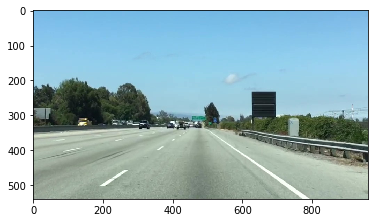

After color selection of (200, 200, 200)


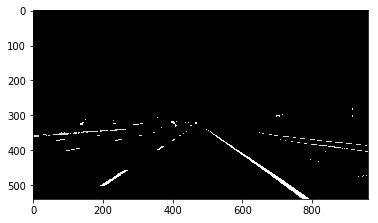

In [6]:
# NOTE: Always make a copy of arrays or other variables in Python
# Read in the image and print out some stats
image = mpimg.imread('Lesson2/test.jpg')
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

# Define our color selection criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image
print("\nOriginal Image")
plt.imshow(image)
plt.show()
print("After color selection of (200, 200, 200)")
plt.imshow(color_select)
plt.show()

# Uncomment the following code if you are running the code locally and wish to save the image
mpimg.imsave("Lesson2/test-after.jpg", color_select)

## Region of Interest

Assuming that the camera is mounted on a fixed position in front of the car, then the lane lines will always appear in the same general region of the image.  We can filter out the remaining pixels from the previous output image by only focusing on the pixels in the region of interest.  In the following example a triangle will be used to identify the region of interest.  Any polygon can be used.

[numpy polyfit docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)

[numpy meshgrid docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html)

Region of Interest


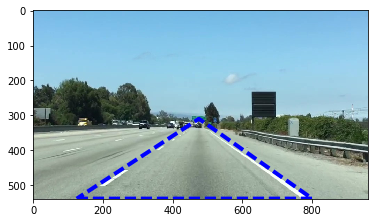

Color Selection + Region of Interest


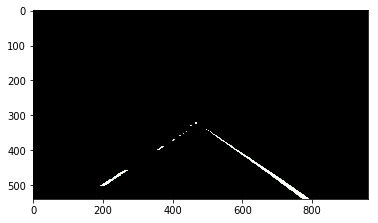

Lines Painted on Road


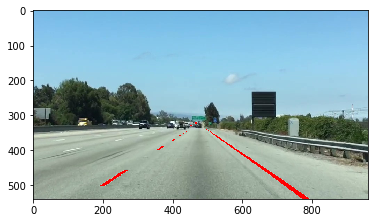

In [15]:
# Read in the image and print some stats
image = mpimg.imread('Lesson2/test.jpg')

# Grab the x and y sizes and make two copies of the image
# With one copy we'll extract only the pixels that meet our selection,
# then we'll paint those pixels red in the original image to see our selection 
# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a triangle region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
left_bottom = [125, 539]
right_bottom = [800, 539]
apex = [475, 310]

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
        
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

# Display the image and show region and color selections
print("Region of Interest")
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.show()

print("Color Selection + Region of Interest")
plt.imshow(color_select)
plt.show()
print("Lines Painted on Road")
plt.imshow(line_image)
plt.show()

## Canny Edge Detection
Developed by [John F Canny](https://en.wikipedia.org/wiki/John_Canny) in 1986.

#### Goal
Identify the boundries of an object on an image.

#### Steps
1. Convert to grayscale.
2. Compute the gradient.
3. Find edges be tracing out the pixels that follow the strongest gradients.

#### Calling function in OpenCV
`edges = cv2.Canny(gray, low_threshold, high_threshold)`

Output:  
&nbsp;&nbsp;&nbsp;&nbsp;edges: Binary image with white pixels tracing out the detected edges and black everywhere else.

Input:  
&nbsp;&nbsp;&nbsp;&nbsp;gray: Image that will have canny applied to it  
&nbsp;&nbsp;&nbsp;&nbsp;low_threshold: Pixels below this threshold will be rejected  
&nbsp;&nbsp;&nbsp;&nbsp;high_threshold: Will first detect strong edge pixels above this threshold
    
**Pixel values between both thresholds will be included as long as they are connected to strong edges**

[OpenCV 2.4 C++ Docs](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)  
[OpenCV 3.2 Python Docs](http://docs.opencv.org/master/da/d22/tutorial_py_canny.html)

Resonable range for parameters?  Pixel values range from 0 to 255. **A reasonable range for your threshold parameters would also be in the tens to hundreds. A low to high ratio of 1:2 or 1:3 (John Canny recommended this himself)**

We will apply Guassian smoothing first, even though the Canny function already does this internally.  You can choose the kernel_size for Gaussian smoothing to be any odd number. A larger kernel_size implies averaging, or smoothing, over a larger area.

Guassian blur with kernel = 3


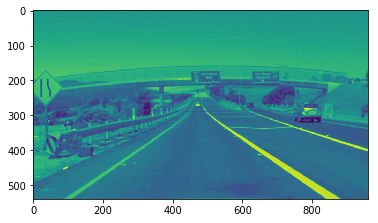

Guassian blur with kernel = 5


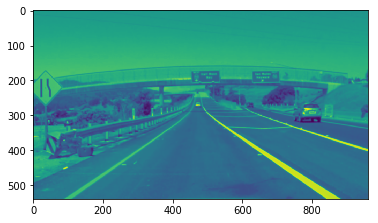

Guassian blur with kernel = 15


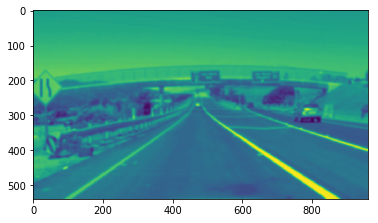

low_threshold = 25	high_threshold = 50


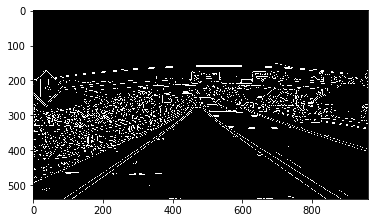

low_threshold = 50	high_threshold = 150


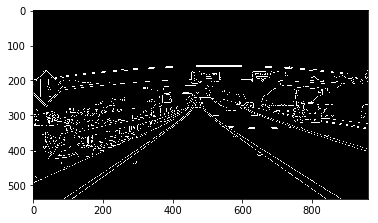

low_threshold = 75	high_threshold = 220


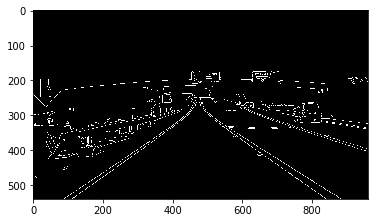

In [36]:
# Read in the image and convert to grayscale
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
image = mpimg.imread('Lesson2/exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
kernel_size_3 = 3 # Must be an odd number (3, 5, 7...)
kernel_size_5 = 5
kernel_size_15 = 15
blur_gray_3 = cv2.GaussianBlur(gray,(kernel_size_3, kernel_size_3),0)
blur_gray_5 = cv2.GaussianBlur(gray,(kernel_size_5, kernel_size_5),0)
blur_gray_15 = cv2.GaussianBlur(gray,(kernel_size_15, kernel_size_15),0)

print("Guassian blur with kernel = 3")
plt.imshow(blur_gray_3)
plt.show()
print("Guassian blur with kernel = 5")
plt.imshow(blur_gray_5)
plt.show()
print("Guassian blur with kernel = 15")
plt.imshow(blur_gray_15)
plt.show()

# Define our parameters for Canny and run it
low_threshold = 25
high_threshold = 50
edges = cv2.Canny(blur_gray_5, low_threshold, high_threshold)

# Display the image
print("low_threshold = {}\thigh_threshold = {}".format(low_threshold, high_threshold))
plt.imshow(edges, cmap='Greys_r')
plt.show()

# Define our parameters for Canny and run it
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray_5, low_threshold, high_threshold)

# Display the image
print("low_threshold = {}\thigh_threshold = {}".format(low_threshold, high_threshold))
plt.imshow(edges, cmap='Greys_r')
plt.show()

# Define our parameters for Canny and run it
low_threshold = 75
high_threshold = 220
edges = cv2.Canny(blur_gray_5, low_threshold, high_threshold)

# Display the image
print("low_threshold = {}\thigh_threshold = {}".format(low_threshold, high_threshold))
plt.imshow(edges, cmap='Greys_r')
plt.show()

## Hough Transform
In image space, a line is plotted as x vs y.  
In Hough space, a line is a ploint in m vs b  
Hough Transform is the conversion image space -> Hough space

![Parallel Lines in Image Space](Lesson2/22-q-hough-intro-quiz.png)

To find lines in Image space, look for intersecting lines in Hough space.
1. Divide Hough space into grids.
2. Define intersecting lines as all lines passing through a given grid cell  


1. First run canny, consider every point in edge detected image as a line in houghspace.
2. Where many lines intersect, we have found a collection of points that defines a line in image |space.

**Problem:** Vertical lines have slop of 0  
**Solution:** Redefine line in polar coordinates.  
Image Space: $x\cos\theta_0 + y\sin\theta_0 = \rho_0$  
$\rho$ = the distance of the line from the origin  
$\theta$ = the angle away from horizontal
![Polar Coordinates for image space](Lesson2/image-space-polar-coords.png)

**A line in image space translates to a bunch of sin curves in Hough Space.  Where the curves intersect, you have a line in image space**
![Line in Image Space](Lesson2/line-to-sin.png)